# Computing the PCA of a Trees for BW2508 Dataset

In [52]:
import os
os.chdir("/home/nati/source/dinov3")
import sys
sys.path.append("/home/nati/source/ml-common/src")

In [ ]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import urllib

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from sklearn.decomposition import PCA
from scipy import signal

from dino_bw.dino_embeddings_utils import setup_patch_quantization_filter, load_dinov3_model, get_class_idx_from_name, extract_patch_features
from dino_bw.bw_defs import MODEL_TO_NUM_LAYERS
from bw_ml_common.datasets.data_accessor_factory import create_dataset_accessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
DEFAULT_PATCH_SIZE = 16
DEFAULT_IMAGE_SIZE = 768
DATASET_PATH = Path("/home/nati/source/datasets/bw2508")
DEFAULT_DINOV3_LOCATION = Path("/home/nati/source/dinov3")
MODEL_NAME = "dinov3_vits16"
DEFAULT_CHECKPOINT_PATH = Path("/home/nati/source/dinov3/checkpoints/dinov3_vits16_pretrain.pth")
class_name = "tree"

In [18]:
patch_quant_filter = setup_patch_quantization_filter(DEFAULT_PATCH_SIZE)
model = load_dinov3_model(DEFAULT_DINOV3_LOCATION, MODEL_NAME, DEFAULT_CHECKPOINT_PATH)

INFO: using base=100 for rope new
INFO: using min_period=None for rope new


INFO: using max_period=None for rope new
INFO: using normalize_coords=separate for rope new
INFO: using shift_coords=None for rope new
INFO: using rescale_coords=2 for rope new
INFO: using jitter_coords=None for rope new
INFO: using dtype=fp32 for rope new
INFO: using mlp layer as FFN


Loading DINOv3 model: dinov3_vits16
Model loaded successfully


In [42]:
clf_path = Path("/home/nati/source/dataOut/dinov3/dino_bw/fg_classifier_tree_c_0.1.pkl")
with open(clf_path, 'rb') as file:
    clf = pickle.load(file)

In [34]:
n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]
accessor = create_dataset_accessor(dataset_name=DATASET_PATH.stem, data_root=str(DATASET_PATH.parent),
                                       split_name="val")
accessor.update_lookup_tables_with_task()
samples = accessor.populate(stable=True)
class_idx = get_class_idx_from_name(accessor, class_name)
samples = accessor.populate(stable=True)

Data Accessor - INFO - [dataset_accessor.py:344] - Accessor bw2508/val: Reading samples from /home/nati/source/datasets/bw2508/splits/val.txt
Data Accessor - INFO - [dataset_accessor.py:182] - Accessor bw2508/val: Using 100 samples.
Data Accessor - INFO - [dataset_accessor.py:592] - Created LUT of size: 16777216, with target classes: 16


In [ ]:
i = 0
# Calculate image features and fg_score
chosen_sample = samples[i]
image_path = chosen_sample["image_path"]
mask_path = chosen_sample["labels_mask_path"]
image = accessor.read_image(image_path)
rgb_mask_img = accessor.read_labels_mask(mask_path)
class_labels = accessor.convert_rgb_mask_to_labels(rgb_mask_img)
features, model_img_size = extract_patch_features(image, model, n_layers, DEFAULT_IMAGE_SIZE, DEFAULT_PATCH_SIZE)
h_patches, w_patches = [int(d / DEFAULT_PATCH_SIZE) for d in model_img_size]
fg_score = clf.predict_proba(features)[:, 1].reshape(h_patches, w_patches)

# Direct foreground calculation
fg_score_resized = cv2.resize(fg_score, dsize=image.size, interpolation=cv2.INTER_NEAREST)
fg_score_mf_image_res = torch.from_numpy(signal.medfilt2d(fg_score_resized, kernel_size=3))

# PCA Calculation
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))
foreground_selection = fg_score_mf.view(-1) > 0.5
fg_patches = features[foreground_selection]
pca = PCA(n_components=3, whiten=True)
pca.fit(fg_patches)

# Apply PCA projection to image
projected_image = torch.from_numpy(pca.transform(features.numpy())).view(h_patches, w_patches, 3)
projected_image = torch.nn.functional.sigmoid(projected_image.mul(2.0)).permute(2, 0, 1)
projected_image *= (fg_score_mf.unsqueeze(0) > 0.5)
projected_img_resized = cv2.resize(projected_image.permute(1, 2, 0).numpy(), dsize=image.size,interpolation=cv2.INTER_LINEAR)


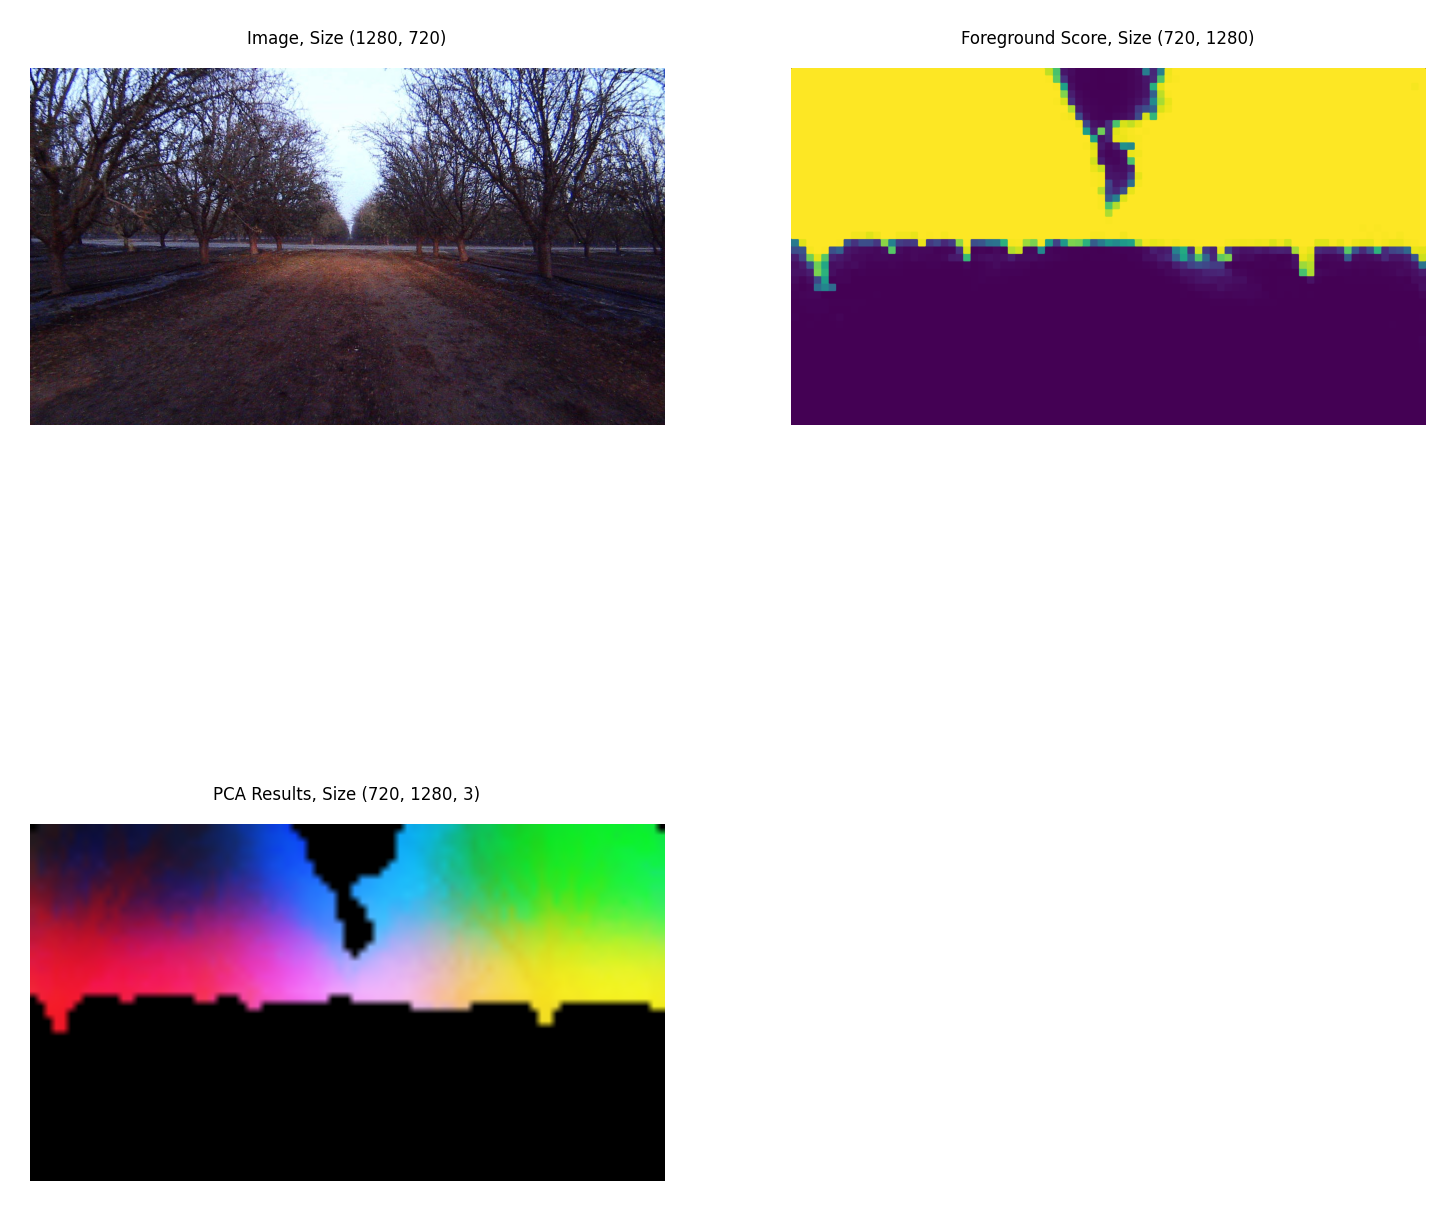

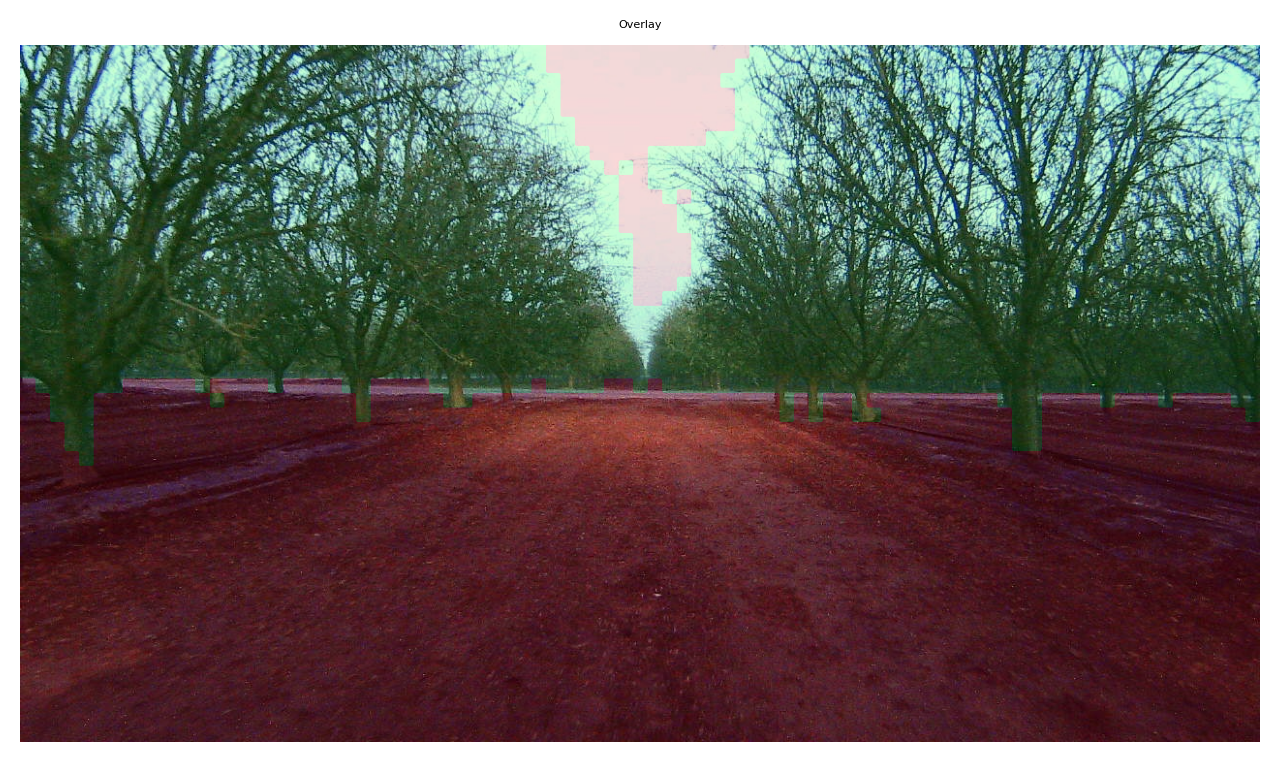

In [ ]:
# Plot results for given Sample (Enable either saving or presenting)
plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
    "axes.titlesize": 4,
})

plt.figure(figsize=(6, 6), dpi=300)
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title(f"Image, Size {image.size}")
plt.subplot(2, 2, 2)
plt.imshow(fg_score_mf)
plt.title(f"Foreground Score, Size {tuple(fg_score_mf.shape)}")
# plt.colorbar()
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(projected_img_resized)
plt.title(f"PCA Results, Size {tuple(projected_img_resized.shape)}")
plt.axis('off')
plt.show()

# Create an overlay for visualization
h, w = fg_score_mf.shape
overlay_rgba = np.zeros((h, w, 4), dtype=np.float32)
overlay_rgba[(fg_score_mf >= 0.5).numpy()] = [0, 1, 0, 0.15]  # Green
overlay_rgba[(fg_score_mf < 0.5).numpy()] = [1, 0, 0, 0.15]   # Red

plt.figure(figsize=(8, 8), dpi=200)
plt.imshow(image)
plt.imshow(overlay_rgba)
plt.axis('off')
plt.title("Overlay")
plt.show()

### Loading an Image and Applying the Right Transform
Let's load an image and process it in order to make it a multiple of the patch size.

In [6]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

image_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/pca/test_image.jpg"

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")
        
# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

image = load_image_from_url(image_uri)
image_resized = resize_transform(image)
image_resized_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

### Model Forward
Given the input image, we compute local features:

In [11]:
MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]
with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        feats = model.get_intermediate_layers(image_resized_norm.unsqueeze(0).cuda(), n=range(n_layers), reshape=True, norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

### Computing Foreground Probability
Let's now pass all those features through our foreground classifier, extract probabilities, and reshape.

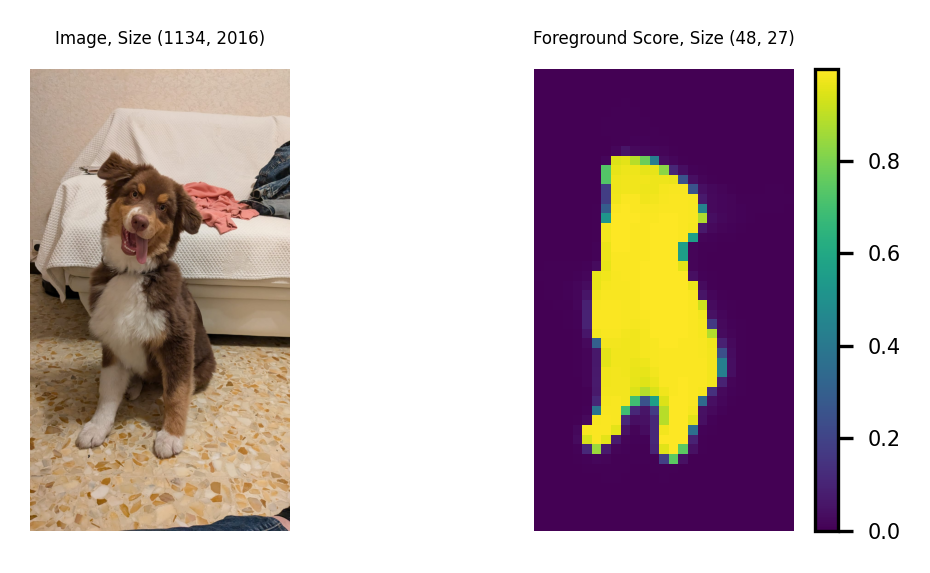

In [18]:
h_patches, w_patches = [int(d / PATCH_SIZE) for d in image_resized.shape[1:]]

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
    "axes.titlesize": 4,
})

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title(f"Image, Size {image.size}")
plt.subplot(1, 2, 2)
plt.imshow(fg_score_mf)
plt.title(f"Foreground Score, Size {tuple(fg_score_mf.shape)}")
plt.colorbar()
plt.axis('off')
plt.show()

### Extracting Foreground Patches
We find the patches with positive classifier output, in order to fit the PCA only on the foreground.

In [ ]:
foreground_selection = fg_score_mf.view(-1) > 0.5
fg_patches = x[foreground_selection]

### Fitting the PCA
We use 3 components, and use whitening. 

In [25]:
fg_score_mf.shape

torch.Size([48, 27])

### Applying the PCA, and Masking Background
Finally, we project the features using the PCA, and apply a mask to set the background to black.

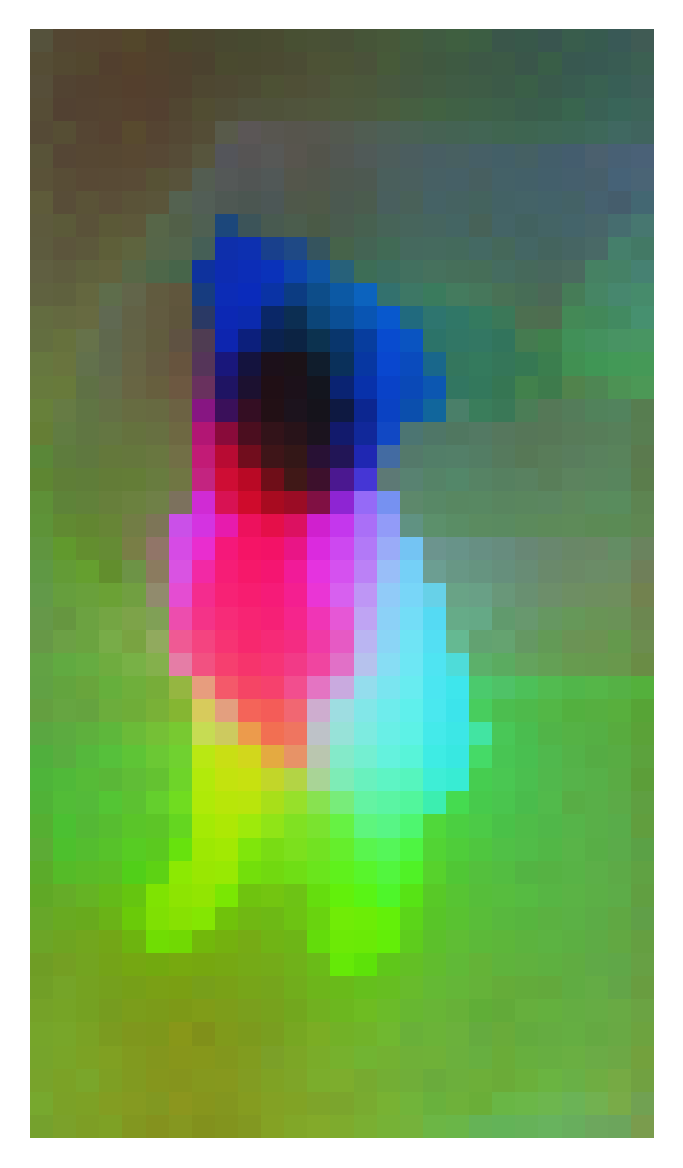

In [27]:
# apply the PCA, and then reshape
projected_image = torch.from_numpy(pca.transform(x.numpy())).view(h_patches, w_patches, 3)

# multiply by 2.0 and pass through a sigmoid to get vibrant colors 
projected_image = torch.nn.functional.sigmoid(projected_image.mul(2.0)).permute(2, 0, 1)

# mask the background using the fg_score_mf
projected_image #*= (fg_score_mf.unsqueeze(0) > 0.5)

# enjoy
plt.figure(dpi=300)
plt.imshow(projected_image.permute(1, 2, 0))
plt.axis('off')
plt.show()